# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict, Counter, deque
from urllib.request import urlretrieve
import gzip
import numpy as np
from pathlib import Path

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [3]:
import heapq

class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt', encoding="utf-8") as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        idx = self.word2id[word]
        return self.embeddings[idx]
    
    def score(self, word1, word2):
        # Retrieve the word embeddings
        embedding1 = self.encode(word1)
        embedding2 = self.encode(word2)
        # Compute their norms
        norm1 = np.linalg.norm(embedding1)
        norm2 = np.linalg.norm(embedding2)
        # Return cosine similarity
        return embedding1.T@embedding2/(norm1 * norm2)
    
    def most_similar(self, word, k=5):
        # Use a heap to keep track of the k most similar words
        # heapq implements a min heap based priority queue
        heap = []
        heapq.heapify(heap)
        
        for other_word in self.words:
            if other_word == word:
                # Ignore self
                continue
            # Compute score
            score = self.score(word, other_word)

            # Store the k words with the largest similarity score
            if len(heap) < k:
                heapq.heappush(heap, (score, other_word))
            else:
                heapq.heappushpop(heap, (score, other_word))
        
        return [word for score, word in reversed(sorted(heap))]

In [4]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50_000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'puppies', 'Dogs', 'pets']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [5]:
from collections import Counter, deque

class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
        
    def df(self, word, sentences):
        # Compute the document frequency of a word, 
        # i.e. the number of sentences in which it appears
        return len([word in sentence for sentence in sentences])
    
    def build_idf(self, sentences):
        words = deque()
        N = len(sentences)
        for sentence in sentences:
            words.extend(np.unique(sentence.split(' ')[:-1]))
        df = Counter(words)
        idf = {word: np.log(1 + N/count) for (word, count) in df.items()}
        return idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        # Split the sentence into words, and keep only known words
        words = set(sentence.split(' ')[:-1]) & set(self.word2vec.words)

        if len(words) == 0:
            return np.zeros(self.word2vec.embeddings[0].shape)
        
        # Compute word embeddings, ignoring the unknown ones (out of vocabulary)
        embeddings = np.vstack([self.word2vec.encode(word) for word in words])
        
        if idf is None:
            # mean of word vectors
            return np.average(embeddings, axis=0)
        else:
            # idf-weighted mean of word vectors
            words_idf = [idf.get(word, 0) for word in words]
            return np.ma.average(embeddings, weights=words_idf, axis=0)

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        embedding1 = self.encode(sentence1, idf)
        embedding2 = self.encode(sentence2, idf)
        
        norm1 = np.linalg.norm(embedding1)
        norm2 = np.linalg.norm(embedding2)
        
        return embedding1.T@embedding2 / (norm1 * norm2)
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        query = sentence
        
        # Use a heap to keep track of the k most similar words
        # heapq implements a min heap based priority queue
        heap = []
        heapq.heapify(heap)
        
        for key in sentences:
            if key == sentence:
                # Ignore self
                continue
            # Compute score
            score = self.score(query, key, idf)

            # Store the k words with the largest similarity score
            if len(heap) < k:
                heapq.heappush(heap, (score, key))
            else:
                heapq.heappushpop(heap, (score, key))
        
        return [sentence for score, sentence in reversed(sorted(heap))]

In [14]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50_000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7373762431619014
1 smiling african american boy . 
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) a small boy following 4 geese . 
4) 2 female babies eating chips . 
5) a young boy and 2 girls open christmas presents . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6721312183440131
1 smiling african american boy . 
1) two women and 1 man walking across the street . 
2) 5 women and 1 man are smiling for the camera . 
3) 3 males and 1 woman enjoying a sporting event 
4) 1 man singing and 1 man playing a saxophone in a concert . 
5) three police officers 2 male 1 female standing around a girl holding something in her hands . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [6]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        en_words = set(self.en_word2vec.words)
        fr_words = set(self.fr_word2vec.words)
        common_words = en_words & fr_words
        
        en_emb, fr_emb = [], []
        for word in common_words:
            en_idx = self.en_word2vec.word2id[word]
            en_emb.append(self.en_word2vec.embeddings[en_idx])
            fr_idx = self.fr_word2vec.word2id[word]
            fr_emb.append(self.fr_word2vec.embeddings[fr_idx])
        
        X = np.vstack(fr_emb).T
        Y = np.vstack(en_emb).T
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U, _, Vt = np.linalg.svd(Y@X.T)
        W = U@Vt
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        def cosine(vec1, vec2):
            n1 = np.linalg.norm(vec1)
            n2 = np.linalg.norm(vec2)
            return vec1.T@vec2/(n1*n2)
        # 3 - Return the top k English nearest neighbors to the input French word
        query = self.aligned_fr_embeddings[self.fr_word2vec.word2id[fr_word]]
        heap = []; heapq.heapify(heap)
        
        for idx, key in enumerate(self.en_word2vec.embeddings):
            score = cosine(query, key)
            if len(heap) < k:
                heapq.heappush(heap, (score, idx))
            else:
                heapq.heappushpop(heap, (score, idx))
        return [self.en_word2vec.id2word[idx] for score, idx in reversed(sorted(heap))]


In [16]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [7]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

def read_file(filepath, test=False):
    with open(filepath, 'r') as f:
        lines = [line.strip("\n") for line in f]
    
    X = []
    Y = []
    
    for line in lines:
        if test:
            X.append(line)
        else:
            label, sentence = line.split(' ', 1)
            X.append(sentence)
            Y.append(int(label))
    return X, Y

sentences_train, Y_train = read_file(train_filepath)
sentences_dev, Y_dev = read_file(dev_filepath)
sentences_test, _ = read_file(test_filepath, test=True)

In [18]:
# 2 - Encode sentences with the BoV model above

word2vec = Word2Vec(en_embeddings_path, vocab_size=50_000)
sentence2vec = BagOfWords(word2vec)

X_train_avg = [sentence2vec.encode(sentence) for sentence in sentences_train]
X_dev_avg   = [sentence2vec.encode(sentence) for sentence in sentences_dev]
X_test_avg  = [sentence2vec.encode(sentence) for sentence in sentences_test]

idf = sentence2vec.build_idf(sentences_train)
X_train_wavg = [sentence2vec.encode(sentence, idf) for sentence in sentences_train]
X_dev_wavg   = [sentence2vec.encode(sentence, idf) for sentence in sentences_dev]
X_test_wavg  = [sentence2vec.encode(sentence, idf) for sentence in sentences_test]

Loaded 50000 pretrained word vectors


====================    TRAINING    ====================

--------------------------------------------------------------------------------
Fitting: Logistic Regression, using simple word-vector averaging...
Done.

Vector average - Best regularization parameter:  12.0

Mean CV performance on train set:
	- accuracy : 0.41104786205554567
	- recall_micro : 0.41104786205554567
	- precision_micro : 0.41104786205554567
	- f1_micro : 0.41104786205554567
	- f1_macro : 0.34944635994431733
	- roc_auc_ovr : 0.7190373843504394

--------------------------------------------------------------------------------
Fitting: Logistic Regression, using TF-IDF weighted word-vector averaging...
Done.

Weighted vector average - Best regularization parameter:  3.3
Mean CV performance on train set:
	- accuracy : 0.41175030113341266
	- recall_micro : 0.41175030113341266
	- precision_micro : 0.41175030113341266
	- f1_micro : 0.41175030113341266
	- f1_macro : 0.340367388324879
	- roc_auc_ovr : 0.7191606752562697

==

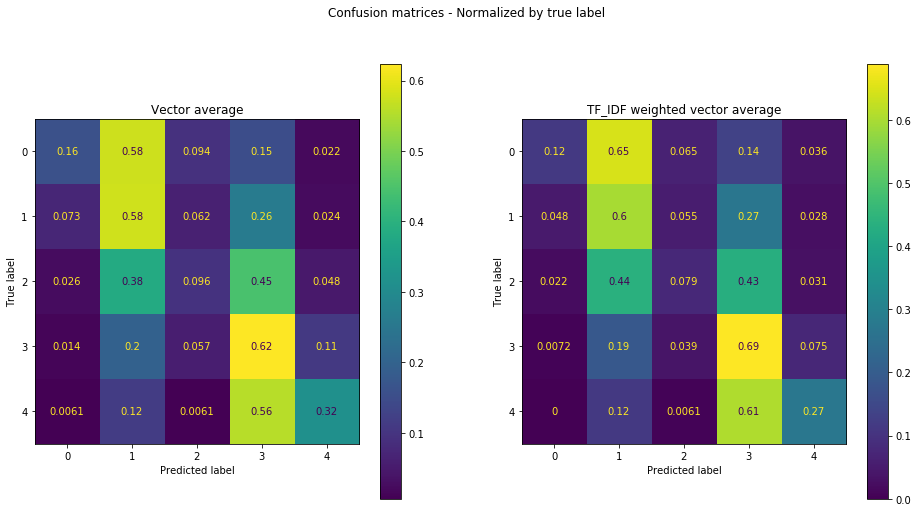


--------------------------------------------------------------------------------
Numerical metrics

Vector average
Macro F1:         0.342
Micro F1:         0.397
Micro Recall:     0.397
Micro Precision:  0.397
Accuracy score:   0.397
Macro ROC AUC:    0.731

Weighted vector average
Macro F1:         0.329
Micro F1:         0.403
Micro Recall:     0.403
Micro Precision:  0.403
Accuracy score:   0.403
Macro ROC AUC:    0.731


In [32]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, recall_score, f1_score, accuracy_score, precision_score, plot_confusion_matrix, roc_auc_score

### TRAIN
print("="*20 + "    TRAINING    " + "="*20)
print()
# Parameters of the Grid Search
params_avg = {"C": np.linspace(12, 12.5, 5)}
params_wavg = {"C": np.linspace(3.3, 3.8, 5)}
reglog = LogisticRegression(solver="newton-cg", multi_class="ovr")
scoring = ['accuracy', 'recall_micro', 'precision_micro', 'f1_micro', 'f1_macro', 'roc_auc_ovr']
clf_kwargs = dict(estimator=reglog, 
                  n_jobs=-1, 
                  scoring=scoring,
                  refit='roc_auc_ovr')

# GridSearcgCV classifiers 
clf_avg, clf_wavg = GridSearchCV(**clf_kwargs, param_grid=params_avg), GridSearchCV(**clf_kwargs, param_grid=params_wavg)

# Averaged vectors
print("-"*80)
print("Fitting: Logistic Regression, using simple word-vector averaging...")
clf_avg.fit(X_train_avg, Y_train)
print("Done.")
print()
print("Vector average - Best regularization parameter: ", clf_avg.best_params_["C"])
print()
print("Mean CV performance on train set:")
for scorer in scoring:
    print('\t-', scorer, ':', clf_avg.cv_results_['mean_test_{}'.format(scorer)][clf_avg.best_index_])
print()

# TF_IDF weighted averaged vectors
print("-"*80)
print("Fitting: Logistic Regression, using TF-IDF weighted word-vector averaging...")
clf_wavg.fit(X_train_wavg, Y_train)
print("Done.")
print()
print("Weighted vector average - Best regularization parameter: ", clf_wavg.best_params_["C"])
print("Mean CV performance on train set:")
for scorer in scoring:
    print('\t-', scorer, ':', clf_wavg.cv_results_['mean_test_{}'.format(scorer)][clf_wavg.best_index_])
print()

### Evaluate performances on dev set

# Confusion matrices
print("="*20 + "    PERFORMANCE EVALUATION - DEV SET    " + "="*20)
print()

print("-"*80)
fig = plt.figure(figsize=(16,8))
fig.suptitle("Confusion matrices - Normalized by true label")
ax = plt.subplot(121)
disp = plot_confusion_matrix(clf_avg, X_dev_avg, Y_dev, normalize='true', ax=ax)
ax.set_title("Vector average")
ax = plt.subplot(122)
disp = plot_confusion_matrix(clf_wavg, X_dev_wavg, Y_dev, normalize='true', ax=ax)
ax.set_title("TF_IDF weighted vector average")
plt.show()
print()

# Numerical metrics
def print_scores(clf, X, Y):
    y_true = Y
    y_pred = clf.predict(X)
    y_score = clf.predict_proba(X)
    print("Macro F1:         {:.3f}".format(f1_score(y_true=y_true, y_pred=y_pred, average="macro")))
    print("Micro F1:         {:.3f}".format(f1_score(y_true=y_true, y_pred=y_pred, average="micro")))
    print("Micro Recall:     {:.3f}".format(recall_score(y_true=y_true, y_pred=y_pred, average="micro")))
    print("Micro Precision:  {:.3f}".format(precision_score(y_true=y_true, y_pred=y_pred, average="micro")))
    print("Accuracy score:   {:.3f}".format(accuracy_score(y_true=y_true, y_pred=y_pred)))
    print("Macro ROC AUC:    {:.3f}".format(roc_auc_score(y_true=y_true, y_score=y_score, 
                                                          average="macro", multi_class='ovr')))

print("-"*80)
print("Numerical metrics")
print()
print("Vector average")
print_scores(clf=clf_avg, X=X_dev_avg, Y=Y_dev)
print()
print("Weighted vector average")
print_scores(clf=clf_wavg, X=X_dev_wavg, Y=Y_dev)


In [33]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

Y_test = clf_wavg.predict(X_test_wavg)

with open("./logreg_bov_y_test_sst.txt", "w+") as fout:
    fout.writelines(map(lambda l: str(l) + "\n", Y_test))


====================    TRAINING    ====================

--------------------------------------------------------------------------------
Fitting: Gradient Boosting Classifier, using simple word-vector averaging...
Done.

Mean performance on train set:
	- accuracy : 0.3954823136364446
	- recall_micro : 0.3954823136364446
	- precision_micro : 0.3954823136364446
	- f1_micro : 0.3954823136364446
	- f1_macro : 0.3539610191952717
	- roc_auc_ovr : 0.6999756517584638

Selecting best performing estimator:
AUC: 0.7077367581929455

--------------------------------------------------------------------------------
Fitting: Gradient Boosting Classifier, using TF-IDF weighted word-vector averaging...
Done.

Mean performance on train set:
	- accuracy : 0.39712138382964957
	- recall_micro : 0.39712138382964957
	- precision_micro : 0.39712138382964957
	- f1_micro : 0.39712138382964957
	- f1_macro : 0.36013455503462294
	- roc_auc_ovr : 0.7104208496798167

Selecting best performing estimator:
AUC: 0.7162

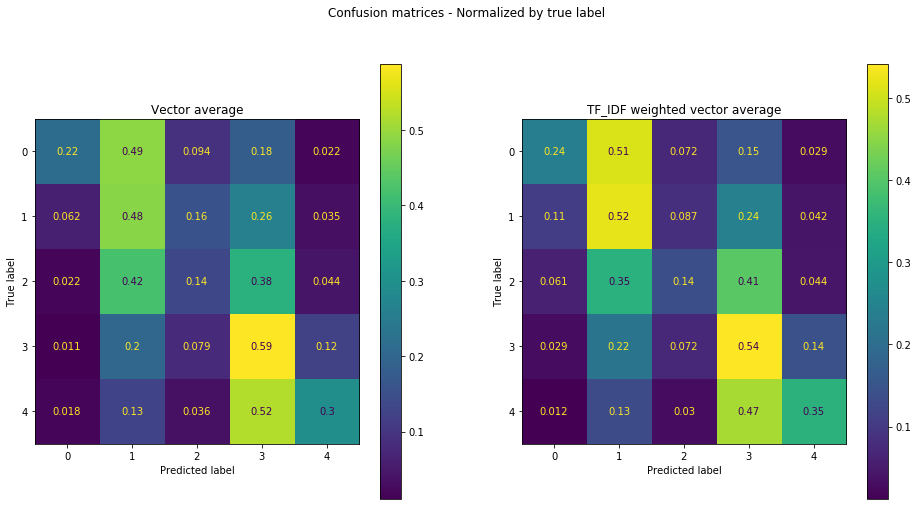


--------------------------------------------------------------------------------
Numerical metrics

Vector average
Macro F1:         0.344
Micro F1:         0.376
Micro Recall:     0.376
Micro Precision:  0.376
Accuracy score:   0.376
Macro ROC AUC:    0.695

Weighted vector average
Macro F1:         0.355
Micro F1:         0.386
Micro Recall:     0.386
Micro Precision:  0.386
Accuracy score:   0.386
Macro ROC AUC:    0.713


In [37]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

### TRAIN
n_estimators=300; lr=0.1

gbc_avg = GradientBoostingClassifier(max_features="sqrt", n_estimators=n_estimators, learning_rate=lr)
gbc_wavg = GradientBoostingClassifier(max_features="sqrt", n_estimators=n_estimators, learning_rate=lr)



print("="*20 + "    TRAINING    " + "="*20)
print()
print("-"*80)
print("Fitting: Gradient Boosting Classifier, using simple word-vector averaging...")
scores = cross_validate(gbc_avg, X_train_avg, Y_train, scoring=scoring, n_jobs=-1, return_estimator=True)
print("Done.")
print()
print("Mean performance on train set:")
for scorer in scoring:
    print('\t-', scorer, ':', np.mean(scores['test_{}'.format(scorer)]))
print()
print("Selecting best performing estimator:")
i_max = np.argmax(scores['test_roc_auc_ovr'])
max_auc = scores['test_roc_auc_ovr'][i_max]
best_gbc_avg = scores["estimator"][i_max]
print("AUC:", max_auc)
print()

print("-"*80)
print("Fitting: Gradient Boosting Classifier, using TF-IDF weighted word-vector averaging...")
scores = cross_validate(gbc_wavg, X_train_wavg, Y_train, scoring=scoring, n_jobs=-1, return_estimator=True)
print("Done.")
print()
print("Mean performance on train set:")
for scorer in scoring:
    print('\t-', scorer, ':', np.mean(scores['test_{}'.format(scorer)]))
print()
print("Selecting best performing estimator:")
i_max = np.argmax(scores['test_roc_auc_ovr'])
max_auc = scores['test_roc_auc_ovr'][i_max]
best_gbc_wavg = scores["estimator"][i_max]
print("AUC:", max_auc)
print()


### Evaluate performances on dev set

# Confusion matrices
print("="*20 + "    PERFORMANCE EVALUATION - DEV SET    " + "="*20)
print()

print("-"*80)
fig = plt.figure(figsize=(16,8))
fig.suptitle("Confusion matrices - Normalized by true label")
ax = plt.subplot(121)
disp = plot_confusion_matrix(best_gbc_avg, X_dev_avg, Y_dev, normalize='true', ax=ax)
ax.set_title("Vector average")
ax = plt.subplot(122)
disp = plot_confusion_matrix(best_gbc_wavg, X_dev_wavg, Y_dev, normalize='true', ax=ax)
ax.set_title("TF_IDF weighted vector average")
plt.show()
print()

# Numerical metrics
def print_scores(clf, X, Y):
    y_true = Y
    y_pred = clf.predict(X)
    y_score = clf.predict_proba(X)
    print("Macro F1:         {:.3f}".format(f1_score(y_true=y_true, y_pred=y_pred, average="macro")))
    print("Micro F1:         {:.3f}".format(f1_score(y_true=y_true, y_pred=y_pred, average="micro")))
    print("Micro Recall:     {:.3f}".format(recall_score(y_true=y_true, y_pred=y_pred, average="micro")))
    print("Micro Precision:  {:.3f}".format(precision_score(y_true=y_true, y_pred=y_pred, average="micro")))
    print("Accuracy score:   {:.3f}".format(accuracy_score(y_true=y_true, y_pred=y_pred)))
    print("Macro ROC AUC:    {:.3f}".format(roc_auc_score(y_true=y_true, y_score=y_score, 
                                                          average="macro", multi_class='ovr')))

print("-"*80)
print("Numerical metrics")
print()
print("Vector average")
print_scores(clf=best_gbc_avg, X=X_dev_avg, Y=Y_dev)
print()
print("Weighted vector average")
print_scores(clf=best_gbc_wavg, X=X_dev_wavg, Y=Y_dev)

Y_test = best_gbc_wavg.predict(X_test_wavg)

with open("./gradient_boosting_bov_y_test_sst.txt", "w+") as fout:
    fout.writelines(map(lambda l: str(l) + "\n", Y_test))

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [13]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

from tensorflow.keras.preprocessing.text import one_hot
from sklearn.preprocessing import OneHotEncoder
vocab_size=50_000

X_train = [one_hot(sentence, vocab_size) for sentence in sentences_train]
X_dev   = [one_hot(sentence, vocab_size) for sentence in sentences_dev]
X_test  = [one_hot(sentence, vocab_size) for sentence in sentences_test]

Encoder = OneHotEncoder(categories=[[i for i in range(5)]], sparse=False)
Y_train = Encoder.fit_transform(np.array(Y_train).reshape(-1,1))
Y_dev = Encoder.transform(np.array(Y_dev).reshape(-1,1))

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [14]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X_train = pad_sequences(X_train, maxlen=max_len)
X_dev   = pad_sequences(X_dev, maxlen=max_len)
X_test  = pad_sequences(X_test, maxlen=max_len)

## 4.2 - Design and train your model

In [59]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW
from tensorflow.keras.models import Sequential
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dropout, GaussianNoise, BatchNormalization

embed_dim  = 300  # word embedding dimension
nhid       = 256  # number of hidden units in the LSTM
vocab_size = 50_000  # size of the vocabulary
fc_dim     = 256
n_classes  = 5

model = Sequential()
# Embedding
model.add(Embedding(vocab_size, embed_dim, mask_zero=True))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 300)         15000000  
_________________________________________________________________
lstm_12 (LSTM)               (None, 256)               570368    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 1285      
Total params: 15,572,677
Trainable params: 15,572,165
Non-trainable params: 512
_________________________________________________________________
None


In [60]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_scheduler = ExponentialDecay(initial_learning_rate=0.01, decay_steps=4, decay_rate=0.96, staircase=False)

loss_classif     =  "categorical_crossentropy"         # find the right loss for multi-class classification
optimizer        =  Adam(learning_rate=lr_scheduler) # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)


In [61]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ADAPT CODE BELOW
bs = 64
n_epochs = 8

checkpointer = ModelCheckpoint(filepath='./models/lstm_weights.hdf5', verbose=1, save_best_only=True)
early_stopper = EarlyStopping(patience=4, restore_best_weights=True)

history = model.fit(X_train, Y_train, 
                    batch_size=bs, epochs=n_epochs, 
                    validation_data=(X_dev, Y_dev), 
                    callbacks=[checkpointer, early_stopper])

Train on 8544 samples, validate on 1101 samples
Epoch 1/8
8512/8544 [============================>.] - ETA: 0s - loss: 1.6193 - accuracy: 0.2950
Epoch 00001: val_loss improved from inf to 1.49984, saving model to ./models/lstm_weights.hdf5
8544/8544 [==============================] - 98s 11ms/sample - loss: 1.6183 - accuracy: 0.2958 - val_loss: 1.4998 - val_accuracy: 0.3778
Epoch 2/8
8512/8544 [============================>.] - ETA: 0s - loss: 0.9479 - accuracy: 0.6133
Epoch 00002: val_loss improved from 1.49984 to 1.42776, saving model to ./models/lstm_weights.hdf5
8544/8544 [==============================] - 102s 12ms/sample - loss: 0.9481 - accuracy: 0.6132 - val_loss: 1.4278 - val_accuracy: 0.3669
Epoch 3/8
8512/8544 [============================>.] - ETA: 0s - loss: 0.5452 - accuracy: 0.8043
Epoch 00003: val_loss did not improve from 1.42776
8544/8544 [==============================] - 98s 12ms/sample - loss: 0.5455 - accuracy: 0.8042 - val_loss: 1.4547 - val_accuracy: 0.3760
Epoc

In [69]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
model.load_weights("./models/lstm_weights.hdf5", by_name=False)
predictions = np.argmax(model.predict(X_test), axis=1)
with open("./logreg_lstm_y_test_sst.txt", "w+") as fout:
    fout.writelines(map(lambda l: str(l) + "\n", predictions))

## 4.3 - innovate !

In [72]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.
import matplotlib.pyplot as plt
import os
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer, Dense, Attention, LayerNormalization, Concatenate, Add
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

from zipfile import ZipFile


##########################################################################
#                                                                        #
#                DATA PREPROCESSING AND PRELIMINARY TASKS                #
#                                                                        #
##########################################################################


#######  PREPROCESS TEXT  #######

def fit_tokenizer(sentences_train):
    """
    Fits a tokenizer on the train set
    
    Args:
        sentences_train: list of str
            Sentences of the train set
    Returns:
        keras.preprocessing.text.Tokenizer, int: fitted tokenizer and the size of the vocabulary 
    """
    t = Tokenizer()
    t.fit_on_texts(sentences_train)
    vocab_size = len(t.word_index) + 1
    return t, vocab_size

def preprocess(train, dev, test, max_len, tokenizer):
    """
    Fits a tokenizer on the train set, tokenizes and pads sequences in all sets with 0s
    
    Args:
        train: list of str
        dev: list of str
        test: list of str
        max_len: int
            Maximum length of the padding
    Returns:
        list of tensors, list of tensors, list of tensors:
            train, dev and test set; tokenized and padded
    """
    X_train = pad_sequences(tokenizer.texts_to_sequences(train), 
                            maxlen=max_len,
                            padding='post')
    X_dev = pad_sequences(tokenizer.texts_to_sequences(dev), 
                            maxlen=max_len,
                            padding='post')
    X_test = pad_sequences(tokenizer.texts_to_sequences(test), 
                            maxlen=max_len,
                            padding='post')
    return X_train, X_dev, X_test
    
# Prepare data
max_len = 60
tokenizer, vocab_size = fit_tokenizer(sentences_train)
X_train, X_dev, X_test = preprocess(sentences_train, sentences_dev, sentences_test, 
                                    max_len=max_len, tokenizer=tokenizer)

#######  LOAD PRE-TRAINED EMBEDDINGS  #######

embedding_dim = 300
GLOVE_PRETRAINED_VECTORS_URL = "http://nlp.stanford.edu/data/glove.42B.300d.zip"
glove_embeddings_path = PATH_TO_DATA / 'glove.42B.300d.txt'
glove_embeddings_archive_path = PATH_TO_DATA / 'glove.42B.300d.zip'

def fetch_pretrained_embeddings(url, filepath, archivepath):
    """
    Fetches and stores pretrained embeddings on disk, if needed
    
    Args:
        url: str
            URL pointing to the GloVe embeddings archive
        filepath: pathlib.Path
            Path to the .txt file where the embeddings should be
        archivepath: pathlib.Path
            Path to where the .zip archive should be
    """
    if not filepath.exists():
        if not archivepath.exists():
            urlretrieve(url, archivepath)

        with ZipFile(acrhivepath, 'r') as archive:
            # Get a list of all archived file names from the zip
            file_list = archive.namelist()
            # Iterate over the file names
            for file_name in file_list:
                # Check filename endswith csv
                archive.extract(file_name, PATH_TO_DATA)

def load_pretrained_embeddings(embeddings_path, tokenizer, vocab_size):
    """
    Loads pretrained embeddings
    
    Args:
        path: pathlib.path
            Path where the .txt file containing the pretrained embeddings is
        tokenizer: keras.preprocessing.text.Tokenizer
            Tokenizer, fitted on the train set
        vocab_size: int
            Size of the vocabulary
    Returns:
        numpy.ndarray: matrix of size vocab_size x embedding_dim containing embeddings for words in the vocabulary
    """
    embeddings_index = dict()
    with open(embeddings_path, 'rt', encoding="utf-8") as f:
        for i, line in enumerate(f):
            word, vec = line.split(' ', 1)
            if word in tokenizer.word_index:
                embeddings_index[word] = np.fromstring(vec, sep=' ')
    print('Loaded %s pretrained word vectors' % (len(embeddings_index)))

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Load pretrained embeddings
fetch_pretrained_embeddings(url=GLOVE_PRETRAINED_VECTORS_URL, filepath=glove_embeddings_path, archivepath=glove_embeddings_archive_path)
embedding_matrix = load_pretrained_embeddings(embeddings_path=glove_embeddings_path,
                                              tokenizer=tokenizer,
                                              vocab_size=vocab_size)

        
##########################################################################
#                                                                        #
#                        ARCHITECTURE DEFINITION                         #
#                                                                        #
##########################################################################

#################        ARCHITECTURE PARAMETERS        ##################

# Embeddings
learned_embedding_dim = 300

# Transformer encoder
att_fc_dim = 256  # Dimension of the Attention residual fully-connected layers
out_fc_dim = 256  # Dimension of the Multi-Head self-attention block output fully-connected layer
heads = 8         # Number of heads in the Multi-Head self-attention block

# Convolutions 
n_filters = 64    # Number of filters in the 1D Convolutional layers
kernel_size = 4   # Kernel size for the 1D Convolutional layers
pool_size = 3     # Pool size for the 1D Maximum Pooling layers

# MLP & classifier
n_classes  = 512   # Number of output dims
dense_width = 512  # Dimension of the fully-connected layers in the classifier head of the network


#################             CUSTOM LAYERS             ##################

class AttentionLayer(Layer):
    def __init__(self, fc_dim, **kwargs):
        super().__init__(**kwargs)
        self.fc_dim = fc_dim
    
    def build(self, input_shape):
        assert isinstance(input_shape, list)
        assert len(input_shape) == 3

        self.query_fc = Dense(self.fc_dim, activation="linear")
        self.value_fc = Dense(self.fc_dim, activation="linear")
        self.key_fc = Dense(self.fc_dim, activation="linear")

        self.att = Attention(use_scale=True)
        super().build(input_shape)
    
    def call(self, inputs):
        assert isinstance(inputs, list)
        query = inputs[0]
        value = inputs[1]
        if len(inputs) > 2 and inputs[2] is not None:
            key = inputs[2]
        else:
            key = value

        query = self.query_fc(query)
        value = self.value_fc(value)
        key = self.key_fc(key)

        return self.att([query, value, key])


class MultiHeadAttention(Layer):
    def __init__(self, n_heads, att_fc_dim, out_fc_dim, **kwargs):
        super().__init__(**kwargs)
        self.n_heads = n_heads
        self.att_fc_dim = att_fc_dim
        self.out_fc_dim = out_fc_dim
    
    def build(self, input_shape):
        assert isinstance(input_shape, list)
        query_shape = input_shape[0]
        # Attention heads
        for head in range(self.n_heads):
            setattr(self, "att_head_{}".format(head), 
                    AttentionLayer(fc_dim=self.att_fc_dim))
        
        self.out_fc = Dense(self.out_fc_dim, activation="linear")
        self.layer_norm1 = LayerNormalization()
        self.concat = Concatenate(axis=-1)        
        super().build(input_shape)

    def call(self, inputs):
        assert isinstance(inputs, list)
        query = inputs[0]
        value = inputs[1]
        if len(inputs) > 2 and inputs[2] is not None:
            key = inputs[2]
        else:
            key = value
        
        heads = []
        for num_head in range(self.n_heads):
            attention_head = getattr(self, "att_head_{}".format(num_head))
            heads.append(attention_head([query, value, key]))
        h = self.concat(heads)
        return self.out_fc(h)


#################          MODEL INSTANTIATION          ##################

#### Input - tokenized sentence
sentence = Input(shape=(max_len,))

#### Embeddings
# Pre-trained GloVe embeddings
e = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)
glove = e(sentence)
# Learned embeddings
learned = Embedding(vocab_size, learned_embedding_dim, input_length=max_len)(sentence)
# Concatenation
x = Concatenate(axis=-1)([glove, learned])

#### Transformaer encoder
x_ = MultiHeadAttention(n_heads=heads, att_fc_dim=att_fc_dim, 
                       out_fc_dim=out_fc_dim)([x, x])
x = Dense(out_fc_dim, activation="relu")(x)
x = Add()([x, x_])
x = LayerNormalization()(x)

x_ = Dense(out_fc_dim, activation="relu")(x_)
x = Add()([x, x_])
x = LayerNormalization()(x)

#### 1D Convolutions
# Conv block 1
x = Dropout(0.25)(x)
x = Conv1D(filters=n_filters, 
           kernel_size=kernel_size,
           activation='relu',
           padding='valid',
           strides=1)(x)
x = MaxPool1D(pool_size)(x)
# Conv block 2
x = Dropout(0.25)(x)
x = Conv1D(filters=n_filters, 
           kernel_size=kernel_size,
           activation='relu',
           padding='valid',
           strides=1)(x)
x = MaxPool1D(pool_size)(x)

#### Pooling
x = GlobalAveragePooling1D()(x)

#### Classifier
# Fully-connected block 1
x = BatchNormalization()(x)
x = Dense(dense_width, activation="relu")(x)
x = Dropout(0.25)(x)
# Fully-connected block 2
x = BatchNormalization()(x)
x = Dense(dense_width, activation="relu")(x)
x = Dropout(0.25)(x)

#### Output
out = Dense(n_classes, activation='softmax')(x)

#### Model instantiation
model = Model(inputs=sentence, outputs=out)
print(model.summary())

##########################################################################
#                                                                        #
#                           TRAINING ROUTINES                            #
#                                                                        #
##########################################################################

#################       TRAINING HYPERPARAMETERS        ##################

lr = 0.01      # Initial learning rate
bs = 256       # Batch size
n_epochs = 10  # Number of epochs
repeats = 3    # Number of fine-tuning iterations

#################             CLASS WEIGHTS             ##################

flat_y = np.argmax(Y_train, axis=1)
weights = class_weight.compute_class_weight('balanced', np.unique(flat_y), flat_y)

#################               CALLBACKS               ##################

early_stopper = EarlyStopping(restore_best_weights=True, patience=2)

#################           TRAINING ROUTINE            ##################

loss_classif     =  'categorical_crossentropy'
metrics_classif  =  ['accuracy']
history = []

for _ in range(repeats):
    lr *= 0.1
    optimizer  =  Adam(learning_rate=lr)

    model.compile(loss=loss_classif,
                  optimizer=optimizer,
                  metrics=metrics_classif)
    
    history.append(model.fit(X_train, Y_train,
                            batch_size=bs, epochs=n_epochs,
                            validation_data=(X_dev, Y_dev),
                            callbacks=[early_stopper],
                            class_weight=class_weight))

##########################################################################
#                                                                        #
#                         EVALUATE PERFORMANCES                          #
#                                                                        #
##########################################################################

predictions = np.argmax(model(X_dev), axis=1)
ground_truth = np.argmax(Y_dev, axis=1)
dev_acc = accuracy_score(y_true=ground_truth, y_pred=predictions)
cfm = confusion_matrix(y_pred=predictions, y_true=ground_truth, normalize="true")
plt.matshow(cfm)
plt.colorbar()
plt.title("Confusion matrix")
plt.show()
print("Accuracy on dev set:", dev_acc)

##########################################################################
#                                                                        #
#                    SAVING RESULTS AND PREDICTIONS                      #
#                                                                        #
##########################################################################

#################              SAVING MODEL             ##################
import os

PATH_TO_MODELS = Path("./models")
if not path.exists():
    os.mkdir(PATH_TO_MODELS)
    
TAG = "_{:.4f}".format(dev_acc)
model_name = "transformer_conv_globavg" + TAG

# Save model weights
weights_path = str(PATH_TO_MODELS / (model_name + "_weights.hdf5"))
model.save_weights(weights_path)

#################     LOAD MODEL AND MAKE PREDICTIONS   ##################

model.load_weights(model_name, by_name=False)
predictions = np.argmax(model.predict(X_test), axis=1)
with open("./transformer_conv_y_test_sst.txt", "w+") as fout:
    fout.writelines(map(lambda l: str(l) + "\n", predictions))


KeyboardInterrupt: 